# Advertiser_SalesModel_Visualization:
---

In [2]:
import os
import us
import math
import mpld3
import cycler
import tabulate
import warnings
import numpy as np
import pandas as pd
import scipy.fftpack
import statsmodels.api
import patsy, patsy.contrasts
import seaborn.apionly as sns
import matplotlib as mpl, matplotlib.pyplot as plt
import cachetools
plt.style.use(['classic'])
warnings.filterwarnings('ignore')
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_categories', 300)
pd.set_option('display.width', 208)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.memory_usage', True)
pd.set_option('display.precision', 7)
%matplotlib inline

---
## Configuration:
---

In [3]:
categorical_encoding = None
master_hdf = 'data/advertiser_master_dataframe.hdf'

---
## Data Sources:
---

In [4]:
with pd.HDFStore(master_hdf) as hdf:
    print(hdf.keys())

['/badcrash_buzz', '/city_sales', '/crash_buzz', '/digi_acts', '/digi_acts_bystate', '/digi_acts_bystate_flat', '/digi_acts_flat', '/digi_acts_raw', '/digi_imps', '/digi_imps_bystate', '/digi_imps_cats', '/digi_imps_cats_bystate', '/digi_imps_cats_bystate_flat', '/digi_imps_cats_flat', '/digi_imps_flat', '/djta', '/fuel', '/fuel_bystate', '/ga', '/ga_bystate', '/gtrends', '/gtrends_bystate', '/merged', '/merged_acts', '/merged_noacts', '/merged_state', '/merged_state_noacts', '/offline', '/sales', '/search_acts', '/search_acts_flat', '/search_imps', '/search_imps_flat', '/social_buzz', '/social_buzz_bystate', '/state_sales', '/yougov']


In [5]:
city_sales = pd.read_hdf(master_hdf, 'city_sales')
state_sales = pd.read_hdf(master_hdf, 'state_sales')
sales = pd.read_hdf(master_hdf, 'sales')
digi_acts = pd.read_hdf(master_hdf, 'digi_acts')
digi_imps = pd.read_hdf(master_hdf, 'digi_imps')
digi_imps_cats_flat = pd.read_hdf(master_hdf, 'digi_imps_cats_flat')
digi_acts_flat = pd.read_hdf(master_hdf, 'digi_acts_flat')
digi_imps_flat = pd.read_hdf(master_hdf, 'digi_imps_flat')
djta = pd.read_hdf(master_hdf, 'djta')
fuel = pd.read_hdf(master_hdf, 'fuel')
ga = pd.read_hdf(master_hdf, 'ga')
gtrends = pd.read_hdf(master_hdf, 'gtrends')
offline = pd.read_hdf(master_hdf, 'offline')
search_acts = pd.read_hdf(master_hdf, 'search_acts')
search_imps = pd.read_hdf(master_hdf, 'search_imps')
search_acts_flat = pd.read_hdf(master_hdf, 'search_acts_flat')
search_imps_flat = pd.read_hdf(master_hdf, 'search_imps_flat')
social_buzz = pd.read_hdf(master_hdf, 'social_buzz')
sales = pd.read_hdf(master_hdf, 'sales')
yougov = pd.read_hdf(master_hdf, 'yougov');

---
## Topline Time Series:
---

In [6]:
ga_topline = pd.DataFrame(ga.groupby(['datebin']).sessions_count.sum(), columns = ['sessions_count']).reset_index()
gtrends_topline = pd.DataFrame(gtrends.groupby(['datebin']).gtrend.mean(), columns = ['gtrend']).reset_index()
fuel_topline = pd.DataFrame(fuel.groupby(['datebin']).fuel_price.mean(), columns = ['fuel_price']).reset_index()
djta_topline = pd.DataFrame(djta.groupby(['datebin']).djta.sum(), columns = ['djta']).reset_index()
socialbuzz_topline = pd.DataFrame(social_buzz.groupby(['datebin']).social_buzz.sum(), columns = ['social_buzz']).reset_index()
search_acts_topline = pd.DataFrame(search_acts.groupby(['datebin']).search_conversions.sum(), columns = ['search_conversions']).reset_index()
search_imps_topline = pd.DataFrame(search_imps.groupby(['datebin']).search_cost.sum(), columns = ['search_cost']).reset_index()
digi_imps_topline = pd.DataFrame(digi_imps.groupby(['datebin']).digi_impressions.sum(), columns = ['digi_impressions']).reset_index()
radio_topline = pd.DataFrame(offline.groupby(['datebin']).radio_cost.sum(), columns = ['radio_cost']).reset_index()
ooh_topline = pd.DataFrame(offline.groupby(['datebin']).ooh_cost.sum(), columns = ['ooh_cost']).reset_index()
sales_topline = pd.DataFrame(sales.groupby(['datebin']).sales.sum(), columns = ['sales']).reset_index()

---
## Initial Plots:
---

In [7]:
def plot_holidays():
    # Easter:
    plt.axvline(x = '2015-04-05', lw = 2, ls = '--', c = '#ff8888', alpha = 0.8)
    plt.axvline(x = '2016-03-27', lw = 2, ls = '--', c = '#ff8888', alpha = 0.8)
    # July 4th:
    plt.axvline(x = '2015-07-02', lw = 2, ls = '--', c = '#aa0000', alpha = 0.8)
    plt.axvline(x = '2016-07-01', lw = 2, ls = '--', c = '#aa0000', alpha = 0.8)
    plt.axvline(x = '2015-07-04', lw = 2, ls = '--', c = '#aa0000', alpha = 0.8)
    plt.axvline(x = '2016-07-04', lw = 2, ls = '--', c = '#aa0000', alpha = 0.8)
    # Labor Day:
    plt.axvline(x = '2014-08-29', lw = 2, ls = '--', c = '#cc00ff', alpha = 0.8)
    plt.axvline(x = '2015-09-04', lw = 2, ls = '--', c = '#cc00ff', alpha = 0.8)
    plt.axvline(x = '2016-09-02', lw = 2, ls = '--', c = '#cc00ff', alpha = 0.8)
    plt.axvline(x = '2014-09-01', lw = 2, ls = '--', c = '#cc00ff', alpha = 0.8)
    plt.axvline(x = '2015-09-07', lw = 2, ls = '--', c = '#cc00ff', alpha = 0.8)
    plt.axvline(x = '2016-09-05', lw = 2, ls = '--', c = '#cc00ff', alpha = 0.8)
    # Thanksgiving:
    plt.axvline(x = '2014-11-26', lw = 2, ls = '--', c = '#8888ff', alpha = 0.8)
    plt.axvline(x = '2015-11-25', lw = 2, ls = '--', c = '#8888ff', alpha = 0.8)
    plt.axvline(x = '2014-11-27', lw = 2, ls = '--', c = '#8888ff', alpha = 0.8)
    plt.axvline(x = '2015-11-26', lw = 2, ls = '--', c = '#8888ff', alpha = 0.8)
    # Santa Claus:
    plt.axvline(x = '2014-12-19', lw = 2, ls = '--', c = '#00aa00', alpha = 0.8)
    plt.axvline(x = '2015-12-18', lw = 2, ls = '--', c = '#00aa00', alpha = 0.8)
    plt.axvline(x = '2014-12-23', lw = 2, ls = '--', c = '#00aa00', alpha = 0.8)
    plt.axvline(x = '2015-12-23', lw = 2, ls = '--', c = '#00aa00', alpha = 0.8)
    plt.axvline(x = '2014-12-25', lw = 2, ls = '--', c = '#00aa00', alpha = 0.8)
    plt.axvline(x = '2015-12-25', lw = 2, ls = '--', c = '#00aa00', alpha = 0.8)

$1,826,465.37


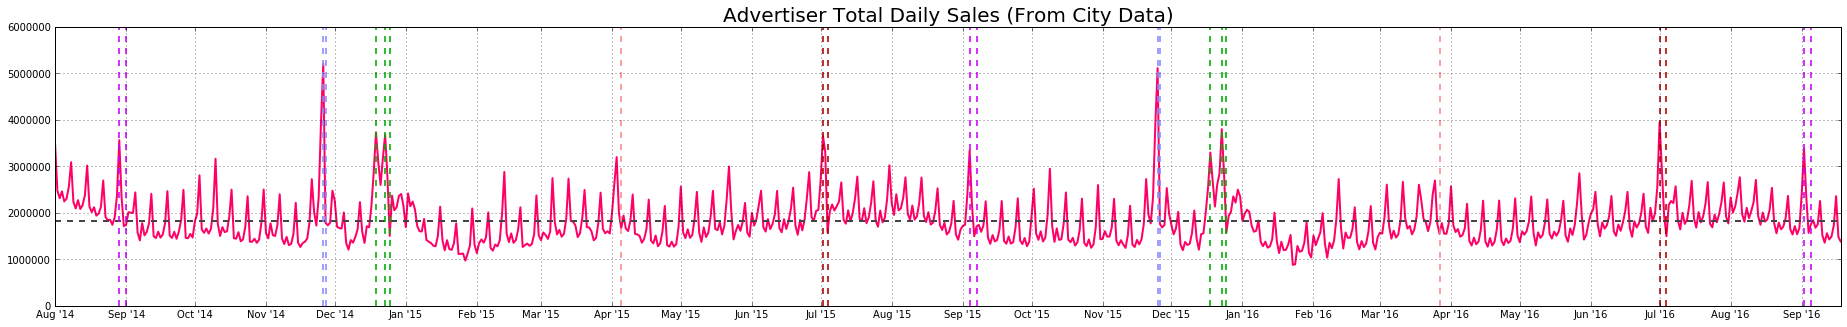

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (32, 5))
ax.plot(sales_topline.datebin, sales_topline.sales, lw = 2, color = '#ff0066')
ax.axhline(y=sales_topline.sales.mean(), linewidth=2, color='#444444', ls='--')
plt.title('Advertiser Total Daily Sales (From City Data)', fontsize='20')
ax.xaxis.set_major_locator(mpl.dates.MonthLocator(range(1, 13), bymonthday=1, interval=1))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%b '%y"))
ax.grid()
plot_holidays()
print('${:,.2f}'.format(sales_topline.sales.mean()))

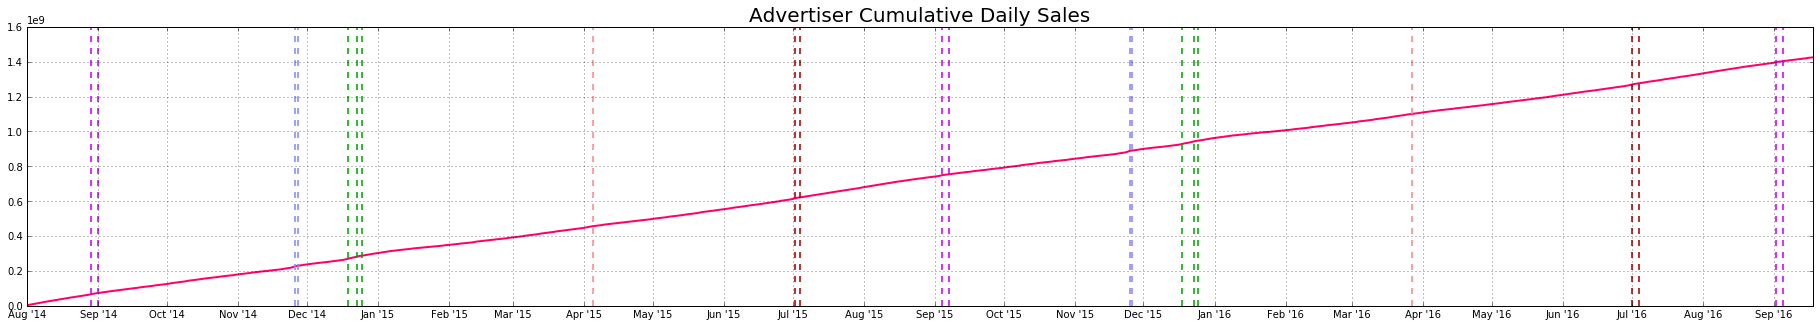

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (32, 5))
sales_topline_cumulative = sales_topline.set_index('datebin').cumsum().reset_index()
ax.plot(sales_topline_cumulative.datebin, sales_topline_cumulative.sales, lw = 2, color = '#ff0066')
plt.title('Advertiser Cumulative Daily Sales', fontsize='20')
ax.xaxis.set_major_locator(mpl.dates.MonthLocator(range(1, 13), bymonthday=1, interval=1))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%b '%y"))
ax.grid()
plot_holidays()

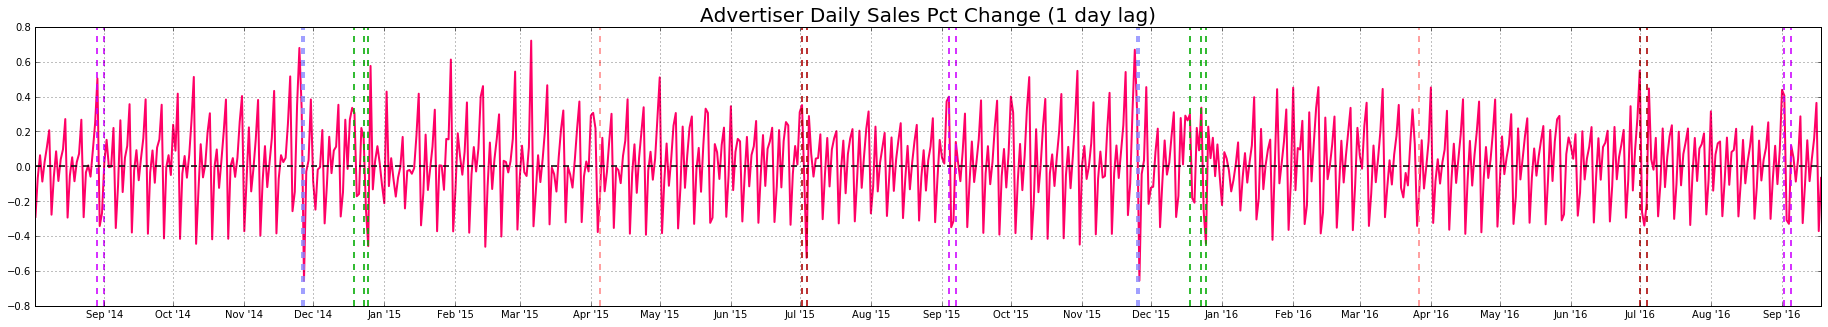

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (32, 5))
sales_topline_pctdiff = sales_topline.set_index('datebin').pct_change().reset_index()
ax.plot(sales_topline_pctdiff.datebin, sales_topline_pctdiff.sales, lw = 2, color = '#ff0066')
plt.title('Advertiser Daily Sales Pct Change (1 day lag)', fontsize='20')
ax.xaxis.set_major_locator(mpl.dates.MonthLocator(range(1, 13), bymonthday=1, interval=1))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%b '%y"))
ax.grid()
plot_holidays()
plt.axhline(y = 0, lw = 2, ls = '--', c = '#111111', alpha = 0.8)

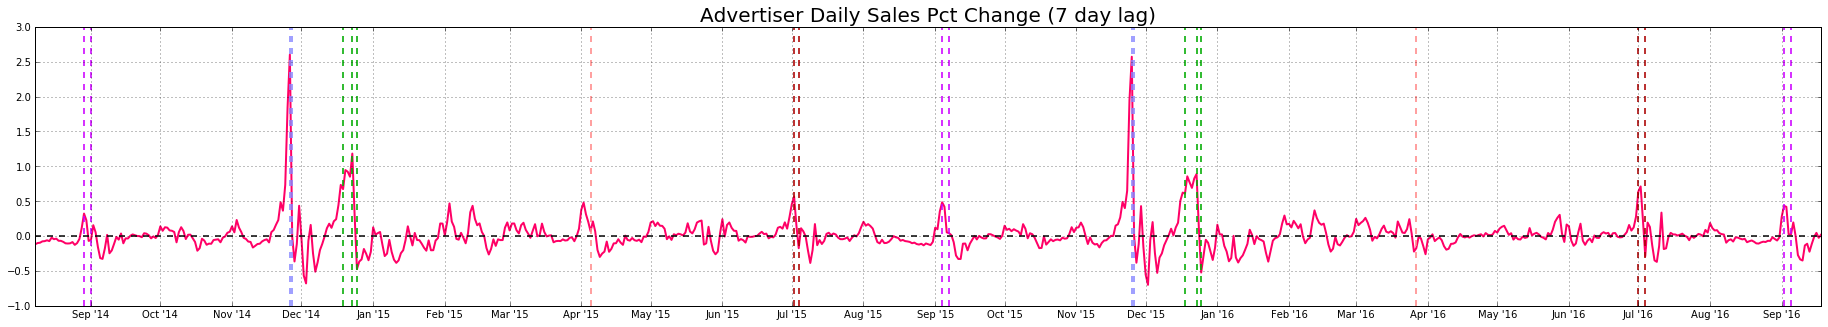

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (32, 5))
sales_topline_pctdiff = sales_topline.set_index('datebin').pct_change(7).reset_index()
ax.plot(sales_topline_pctdiff.datebin, sales_topline_pctdiff.sales, lw = 2, color = '#ff0066')
plt.title('Advertiser Daily Sales Pct Change (7 day lag)', fontsize='20')
ax.xaxis.set_major_locator(mpl.dates.MonthLocator(range(1, 13), bymonthday=1, interval=1))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%b '%y"))
ax.grid()
plot_holidays()
plt.axhline(y = 0, lw = 2, ls = '--', c = '#111111', alpha = 0.8)

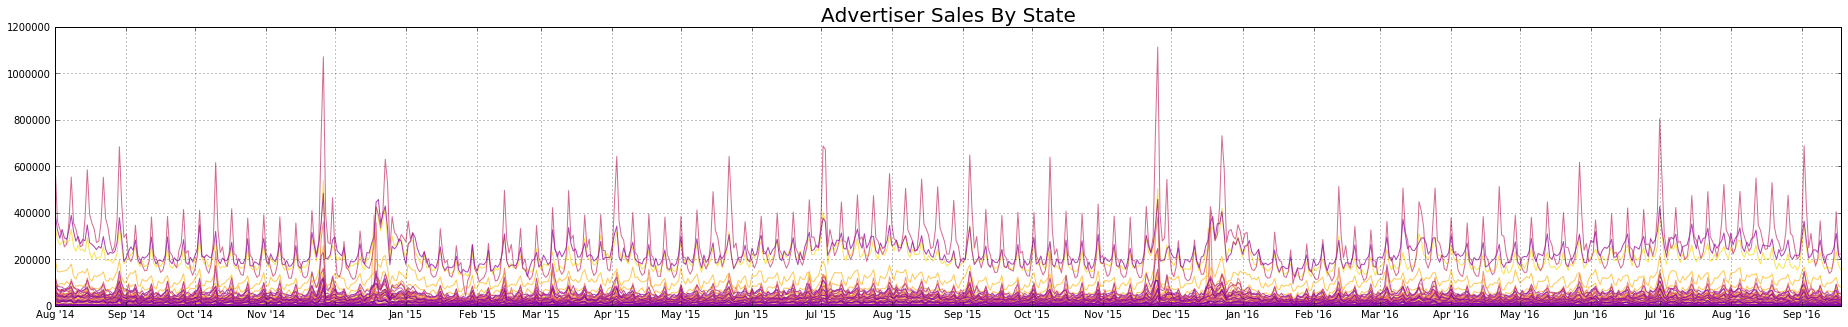

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (32, 5))
numstates = len(us.states.STATES)
ax.set_prop_cycle(cycler.cycler('color', [plt.get_cmap('plasma_r')(0.8*i/numstates) for i in range(numstates)]))
for state in us.states.STATES:
    tdf = state_sales[state_sales.state == state.name]
    plt.plot(tdf.datebin, tdf.sales, lw = 1, alpha = 0.8)
plt.title('Advertiser Sales By State', fontsize='20')
ax.xaxis.set_major_locator(mpl.dates.MonthLocator(range(1, 13), bymonthday=1, interval=1))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%b '%y"))
plt.grid()

['New York', 'Texas', 'California', 'Florida', 'Georgia', 'Pennsylvania']


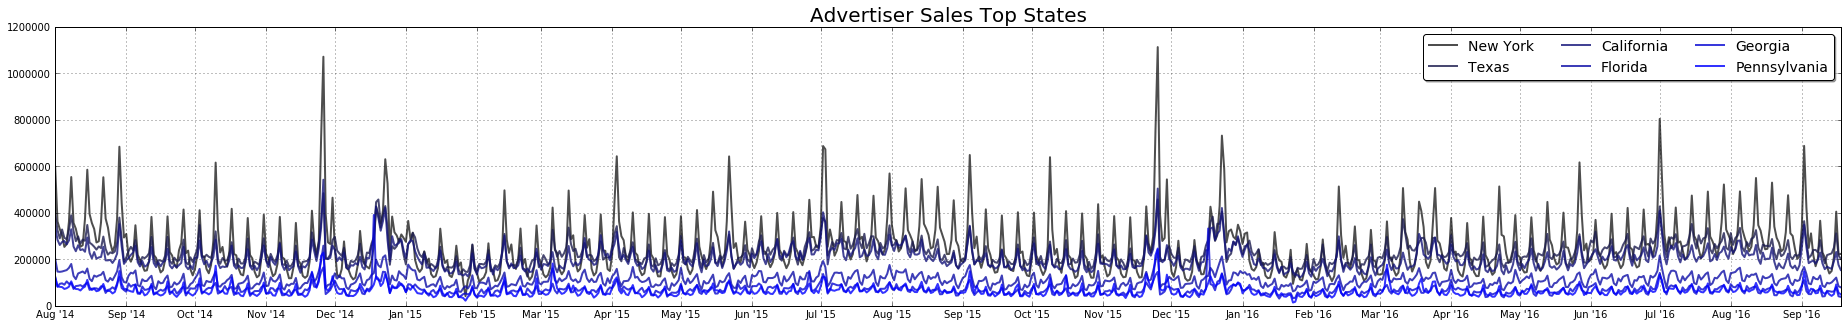

In [13]:
numstates = 6
topstates = state_sales.groupby(['state']).sales.sum().sort_values(ascending = False).index.tolist()[:numstates]
print(topstates)
fig, ax = plt.subplots(1, 1, figsize = (32, 5))
ax.set_prop_cycle(cycler.cycler('color', sns.dark_palette("blue")))
for state in topstates:
    tdf = state_sales[state_sales.state == state]
    ax.plot(tdf.datebin, tdf.sales, label = state, lw = 2, alpha = 0.8)
plt.title('Advertiser Sales Top States', fontsize='20')
ax.legend(numpoints=1, ncol=numstates//2, loc='upper right', fancybox=True, shadow=True, fontsize='14')
ax.xaxis.set_major_locator(mpl.dates.MonthLocator(range(1, 13), bymonthday=1, interval=1))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%b '%y"))
plt.grid()

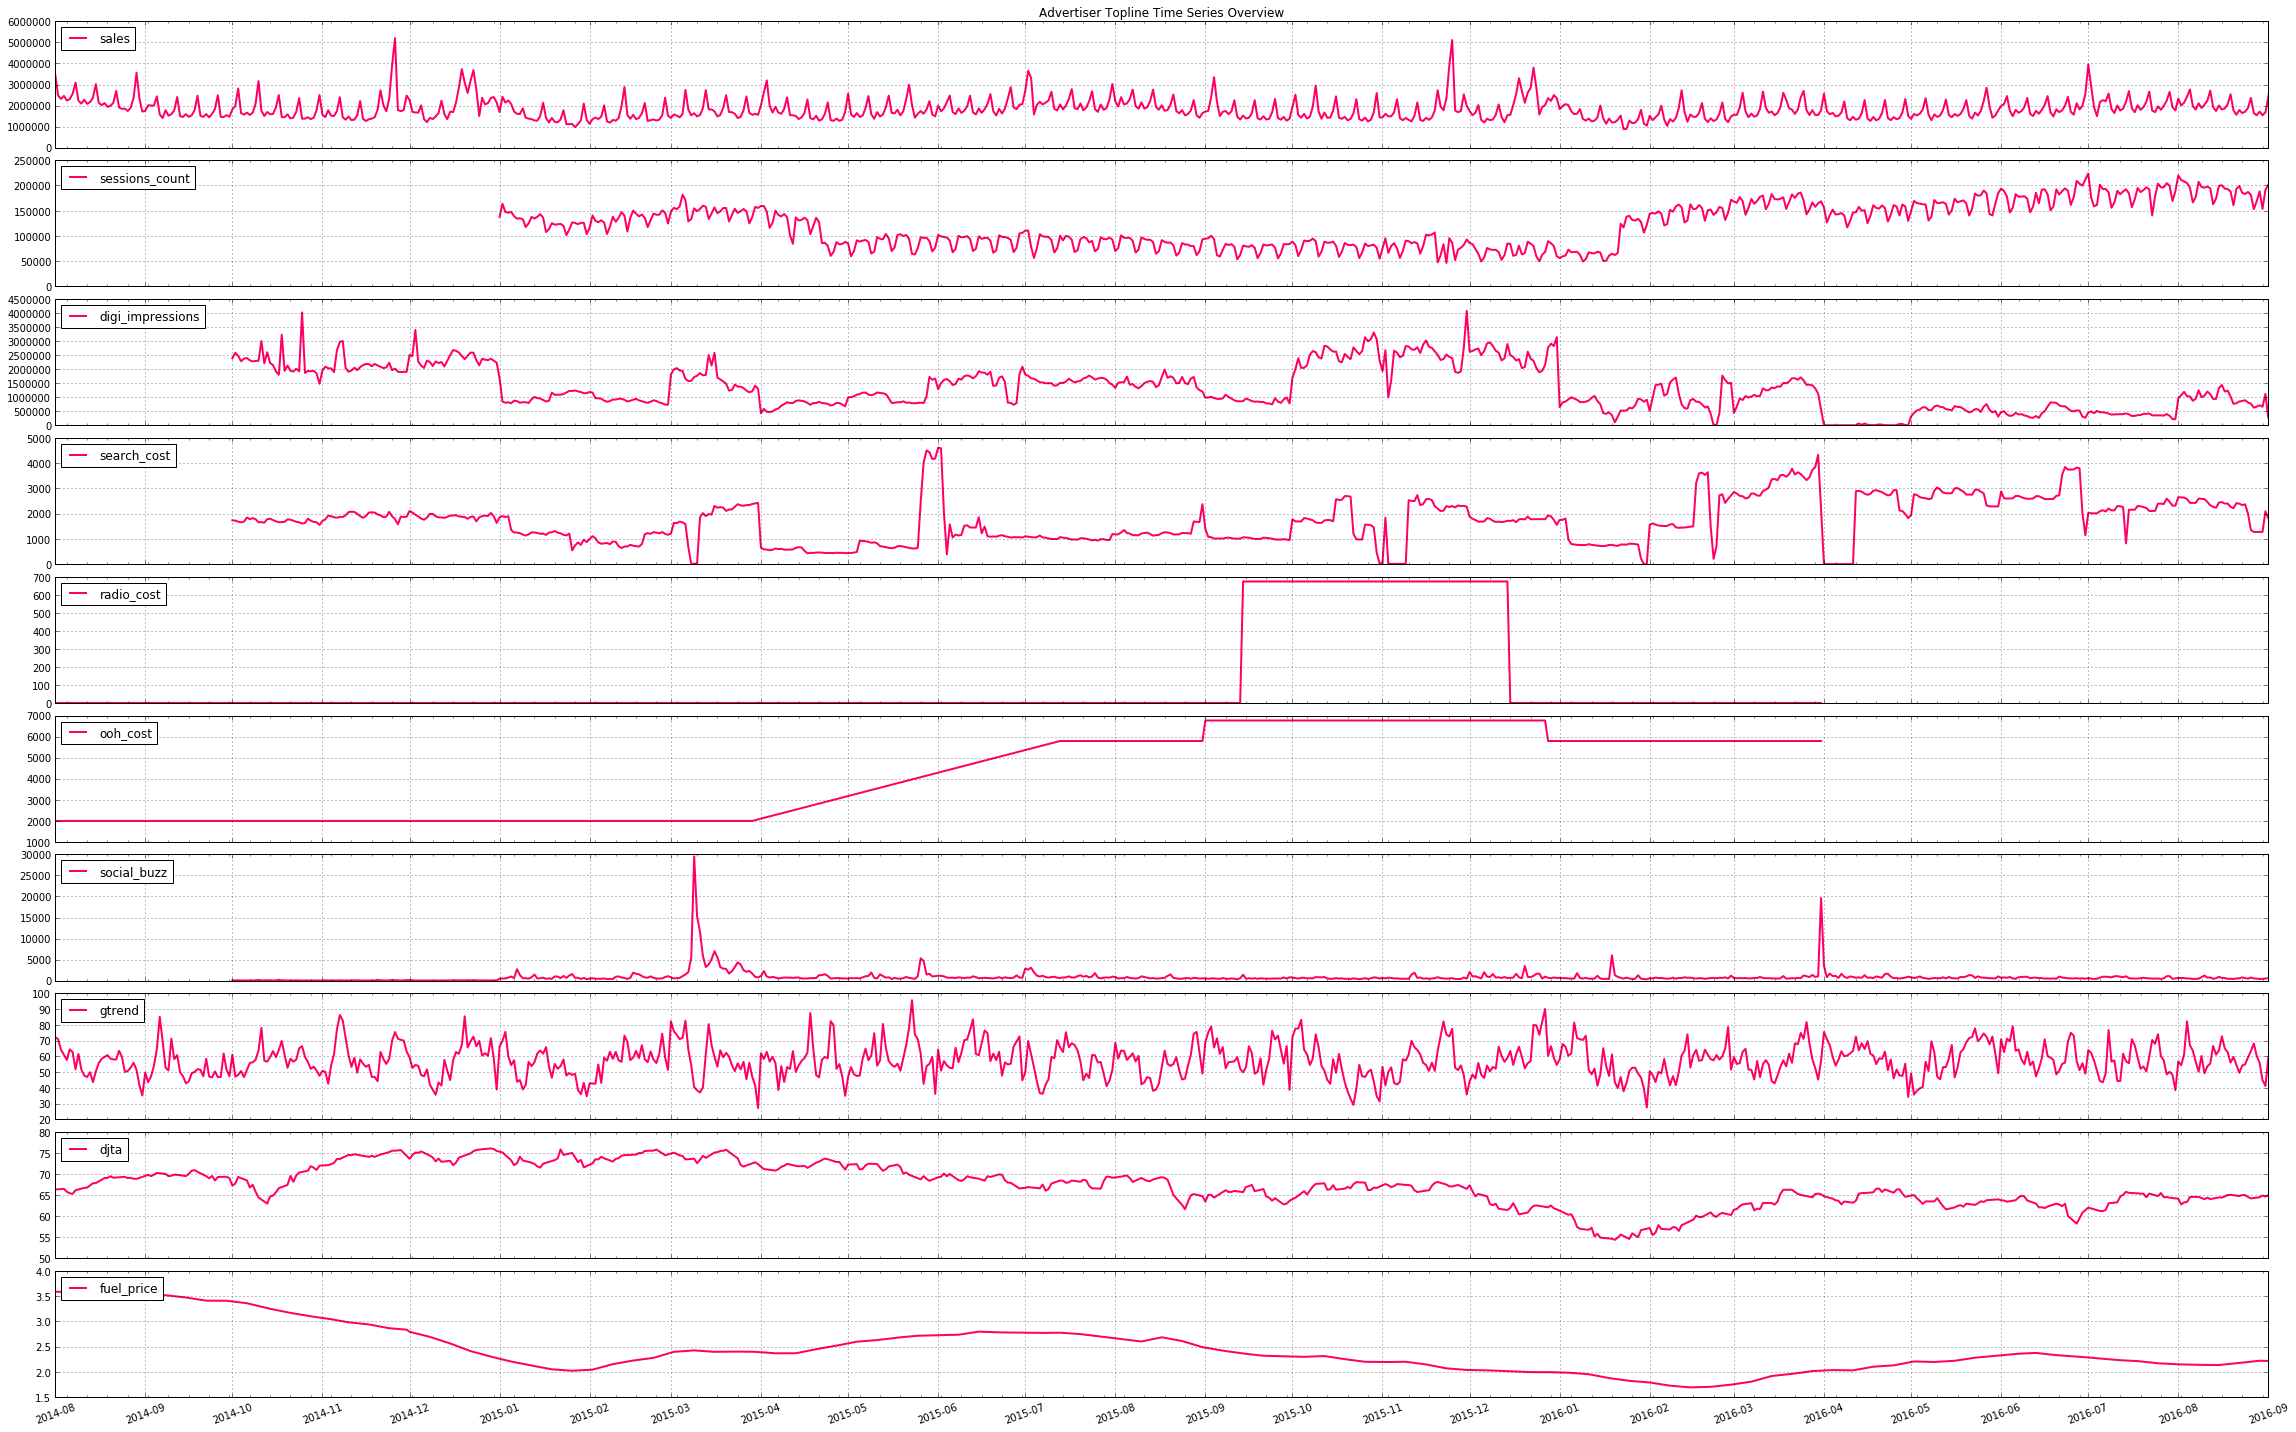

In [14]:
dsets = [sales_topline, ga_topline, digi_imps_topline, search_imps_topline, radio_topline, ooh_topline, socialbuzz_topline, gtrends_topline, djta_topline, fuel_topline]
num_dsets = len(dsets)
fig, axes = plt.subplots(num_dsets, 1, figsize = (32, 2*num_dsets))
plt.xticks(rotation = 20)
for idx in range(num_dsets):
    dset = dsets[idx]
    varname = dset.columns[1]
    ax = axes[idx]
    ax.plot(dset.datebin, dset[varname], lw = 2, label = varname, color = '#ff0066')
    ax.get_xaxis().set_major_locator(mpl.dates.MonthLocator())
    ax.get_xaxis().set_minor_locator(mpl.dates.WeekdayLocator())
    ax.get_xaxis().set_major_formatter(mpl.dates.DateFormatter('%Y-%m'))
    ax.set_xlim(('2014-08-01', '2016-09-01'))
    ax.legend(loc = 'upper left')
    ax.grid()
    if idx == 0:
        ax.set_title('Advertiser Topline Time Series Overview')
    if idx != num_dsets - 1:
        ax.get_xaxis().set_ticklabels([])
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.1)